In [49]:
'''
Author: Evgeny Novozhilov
В рамках данной работы проводится сравнение производительности встроенных в Pytorch оптимизаторов при разном 
значении гиперпараметра LR, применительно к CNN сравниваются оптимизаторы:
- Adam
- SGD: (Momentum = 0.8, Momentum = 0.9)
- RMSProp

Credits:
Исходный пример модели CNN архитектуры и исходный вариант загрузки массива данных
котиков и собачек и ссылок на массив, взяты у mukul54:
https://github.com/mukul54/A-Simple-Cat-vs-Dog-Classifier-in-Pytorch

История изменений:
0.0.1: Доработан механизм загрузки (загрузка из data-файлов npy, настройка путей с категориями, распределение)
0.0.2: Адаптировано под cuda, основные настройки сделаны параметами и вынесены в начало
0.0.3: Переделана логика обучения для возможности работы с 4 разными оптимизаторами
0.0.4: Подключен matplotlib - графики кривой обучения, вывод котиков
0.0.5: Добавлена инициализация весов в модели init.xavier_uniform_
0.0.6: Переключение модели train/eval

TODO:
- Использовать dataloader и доп. аугментации исходного набора, перейти на произвольный minibatch
- Фиксировать веса для всех экспериментов
- Несколько вариантов инициализации весов для каждого вида оптимизатора
- Прекращать эксперимент если динамика плохая, переходить к следующей комбинации гиперпараметров
- Уникальный набор комбинаций гиперпараметров специфичный для каждого оптимизатора
- Использовать более сложную нейросеть




'''
# Импорты

import glob
# Игнорируем некоторые виды предупреждений
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
                        
import inspect
import numpy as np 
#import pandas as pd
#import csv
import torch
import matplotlib.pyplot as plt
import torchvision
import cv2
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from random import shuffle
#from torchsummary import summary

# Подрихтуем настройки по умолчанию для графиков
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%matplotlib inline

# Определим режим выполнения - CPU / GPU
if torch.cuda.is_available(): 
    torch.backends.cudnn.deterministic = True
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu') # короткая ссылка на cpu

# Основные настройки
EPOCH = 5000
max_num_train_samples = 800 # сколько картинок берем (train)
max_num_test_samples = 200 # сколько картинок берем (test)
max_num_val_samples = 200 # сколько картинок берем (val)

shuffle_data = True # перемешать данные
cat_dog_train_path = './input/train/*/*.jpg' # путь к картинкам для train
dimension = 64 # размер результирующих изображений на вход IL
save_image_npy = False # сохранить загруженные с диска картинки в data-файлы npy
load_from_npy = True # вместо загрузки картинок с диска, загрузим data-файлы npy

# Предполагается, что файлы для обучения лежат в директории "./input/"

import os
print(os.listdir("./input"))


['test1', 'train', 'sample', 'valid', 'models']


In [50]:
if load_from_npy == False:
    # Список из путей к каждой картинке
    addrs = glob.glob(cat_dog_train_path)

    # Простановка меток - у нас 2 класса на выходе
    labels = [ [1,0] if 'cat' in addr else [0,1] for addr in addrs]  # 1 = Cat, 0 = Dog


    # Функция определения имени по метке класса
    def get_pet_name(x):
        if x == [1,0]: return 'cat'
        else: return 'dog'

    if shuffle_data:
        c = list(zip(addrs, labels))
        shuffle(c)
        addrs, labels = zip(*c)
        for i,label in enumerate( labels[0:10]):
            print(i,':',get_pet_name(label)) #  проверим, мешалка работает

    # Распределим исходное множество на train, test, validation
    boundary = 0
    train_addrs = addrs[0:max_num_train_samples]
    train_labels = labels[0:max_num_train_samples]
    boundary += max_num_train_samples + 1
    val_addrs = addrs[boundary:boundary+max_num_val_samples]
    val_labels = labels[boundary:boundary+max_num_val_samples]
    boundary += max_num_val_samples + 1
    test_addrs = addrs[boundary:boundary+max_num_test_samples]
    test_labels = labels[boundary:boundary+max_num_test_samples]

In [51]:
# Загрузка данных, исходный вариант загрузки не использует dataloader
# TODO: использовать dataloader с штатным механизмом трансформации исходного набора
    
# Train
if load_from_npy == False:    
    train_data = []

    for i in range(len(train_addrs[:max_num_samples])):
        # загружаем картинку, приводим к нужному размеру, преобразуем BGR->RGB
        addr = train_addrs[i]
        img = cv2.imread(addr)
        img = cv2.resize(img, (dimension, dimension), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_data.append([np.array(img), np.array(train_labels[i])])
    if shuffle_data:
        shuffle(train_data)
    if save_image_npy:
        np.save('train_labels.npy', train_labels)
        np.save('train_data.npy', train_data)
else:
    train_labels = np.load('train_labels.npy',allow_pickle=True)
    print ('train labels:',train_labels.shape)
    train_data = np.load('train_data.npy',allow_pickle=True)
    print ('train data:',train_data.shape)
    

    
    
# Test    
if load_from_npy == False:     
    
    test_data = []
    for i in range(len(test_addrs[:max_num_samples])):
        # загружаем картинку, приводим к нужному размеру, преобразуем BGR->RGB
        addr = test_addrs[i]
        img = cv2.imread(addr)
        img = cv2.resize(img, (dimension, dimension), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_data.append([np.array(img), np.array(labels[i])])
    if shuffle_data:
        shuffle(test_data)
    if save_image_npy:
        np.save('test_data.npy', test_data)
else:
    test_data = np.load('test_data.npy',allow_pickle=True)
    print ('test_data:',test_data.shape)

# Validation      
if load_from_npy == False:    
    val_data = []
    for i in range(len(val_addrs[:max_num_samples])):
        # загружаем картинку, приводим к нужному размеру, преобразуем BGR->RGB
        addr = val_addrs[i]
        img = cv2.imread(addr)
        img = cv2.resize(img, (dimension, dimension), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        val_data.append([np.array(img), np.array(labels[i])])
    if shuffle_data:
        shuffle(val_data)
    if save_image_npy:
        np.save('val_data.npy', val_data)
else:
    val_data = np.load('val_data.npy',allow_pickle=True)
    print ('val_data:',val_data.shape)

train labels: (800, 2)
train data: (800, 2)
test_data: (200, 2)
val_data: (200, 2)


In [48]:
from torch.autograd import Variable
X = np.array([i[0] for i in train_data]).reshape(-1,dimension,dimension,3)
X = Variable(torch.Tensor(X))
X = X.reshape(-1,dimension,dimension,3) # добавим label dim
X = X.permute(0,3,1,2) # перестановка как требует данные PyTorch
print('Вход:',X.shape)
X = X.to(device)



Y = np.array([i[1] for i in train_data])
target = Variable(torch.Tensor(Y))
target = target.type(torch.LongTensor)
print('Выход:',target.shape)
target = target.to(device)



Вход: torch.Size([800, 3, 64, 64])
Выход: torch.Size([800, 2])


In [23]:
class Net(nn.Module):
    name = '' # здесь будем хранить имя оптимизатора который применяем к конкретному экземпляру сети
    
    def __init__(self,num_classes, name=''):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(3, 50, 5)
        torch.nn.init.xavier_uniform_(self.conv_1.weight)
        self.pool_1 = nn.MaxPool2d(2, 2)
        
        self.conv_2 = nn.Conv2d(50, 100, 7)
        torch.nn.init.xavier_uniform_(self.conv_2.weight)
        self.pool_2 = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(100 * 12 * 12, 120)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(120, 100)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(100, 2)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        self.name = name

    def forward(self, x):
        x = self.pool_1(F.relu(self.conv_1(x)))
        x = self.pool_2(F.relu(self.conv_2(x)))
        x = x.view(-1, 100 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

    


In [24]:
# Loss-функция и список для построения графиков
loss_history = []
loss_func = nn.CrossEntropyLoss()



LR = 0.1
Epoch= 0/5000 


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 : SGD 0.6943005919456482
0 : Momentum 0.8089703321456909
0 : RMS 0.7993752956390381
0 : Adam 0.6917467713356018
Epoch= 100/5000 
100 : SGD 0.811261773109436
100 : Momentum 0.811261773109436
100 : RMS 0.811261773109436
100 : Adam 0.811261773109436
Epoch= 200/5000 
200 : SGD 0.811261773109436
200 : Momentum 0.811261773109436
200 : RMS 0.811261773109436
200 : Adam 0.811261773109436
Epoch= 300/5000 
300 : SGD 0.811261773109436
300 : Momentum 0.811261773109436
300 : RMS 0.811261773109436
300 : Adam 0.811261773109436
Epoch= 400/5000 
400 : SGD 0.811261773109436
400 : Momentum 0.811261773109436
400 : RMS 0.811261773109436
400 : Adam 0.811261773109436
Epoch= 500/5000 
500 : SGD 0.811261773109436
500 : Momentum 0.811261773109436
500 : RMS 0.811261773109436
500 : Adam 0.811261773109436
Epoch= 600/5000 
600 : SGD 0.811261773109436
600 : Momentum 0.811261773109436
600 : RMS 0.811261773109436
600 : Adam 0.811261773109436
Epoch= 700/5000 
700 : SGD 0.811261773109436
700 : Momentum 0.81126177310943

800 : SGD 0.8152617812156677
800 : Momentum 0.6931474208831787
800 : RMS 0.8152617812156677
800 : Adam 0.6931474208831787
Epoch= 900/5000 
900 : SGD 0.8152617812156677
900 : Momentum 0.6931474208831787
900 : RMS 0.8152617812156677
900 : Adam 0.6931474208831787
Epoch= 1000/5000 
1000 : SGD 0.8152617812156677
1000 : Momentum 0.6931474208831787
1000 : RMS 0.8152617812156677
1000 : Adam 0.6931474208831787
Epoch= 1100/5000 
1100 : SGD 0.8152617812156677
1100 : Momentum 0.6931474208831787
1100 : RMS 0.8152617812156677
1100 : Adam 0.6931474208831787
Epoch= 1200/5000 
1200 : SGD 0.8152617812156677
1200 : Momentum 0.6931474208831787
1200 : RMS 0.8152617812156677
1200 : Adam 0.6931474208831787
Epoch= 1300/5000 
1300 : SGD 0.8152617812156677
1300 : Momentum 0.6931474208831787
1300 : RMS 0.8152617812156677
1300 : Adam 0.6931474208831787
Epoch= 1400/5000 
1400 : SGD 0.8152617812156677
1400 : Momentum 0.6931474208831787
1400 : RMS 0.8152617812156677
1400 : Adam 0.6931474208831787
Epoch= 1500/5000 
1

1400 : RMS 0.6931474208831787
1400 : Adam 0.811261773109436
Epoch= 1500/5000 
1500 : SGD 0.6931474208831787
1500 : Momentum 0.6931474208831787
1500 : RMS 0.6931474208831787
1500 : Adam 0.811261773109436
Epoch= 1600/5000 
1600 : SGD 0.6931474208831787
1600 : Momentum 0.6931474208831787
1600 : RMS 0.6931474208831787
1600 : Adam 0.811261773109436
Epoch= 1700/5000 
1700 : SGD 0.6931474208831787
1700 : Momentum 0.6931474208831787
1700 : RMS 0.6931474208831787
1700 : Adam 0.811261773109436
Epoch= 1800/5000 
1800 : SGD 0.6931474208831787
1800 : Momentum 0.6931474208831787
1800 : RMS 0.6931474208831787
1800 : Adam 0.811261773109436
Epoch= 1900/5000 
1900 : SGD 0.6931474208831787
1900 : Momentum 0.6931474208831787
1900 : RMS 0.6931474208831787
1900 : Adam 0.811261773109436
Epoch= 2000/5000 
2000 : SGD 0.6931474208831787
2000 : Momentum 0.6931474208831787
2000 : RMS 0.6931474208831787
2000 : Adam 0.811261773109436
Epoch= 2100/5000 
2100 : SGD 0.6931474208831787
2100 : Momentum 0.6931474208831787

2100 : SGD 0.5343770384788513
2100 : Momentum 0.5466240048408508
2100 : RMS 0.6931474208831787
2100 : Adam 0.6931474208831787
Epoch= 2200/5000 
2200 : SGD 0.5331898927688599
2200 : Momentum 0.5463969111442566
2200 : RMS 0.6931474208831787
2200 : Adam 0.6931474208831787
Epoch= 2300/5000 
2300 : SGD 0.5323557257652283
2300 : Momentum 0.545091986656189
2300 : RMS 0.6931474208831787
2300 : Adam 0.6931474208831787
Epoch= 2400/5000 
2400 : SGD 0.5320783257484436
2400 : Momentum 0.5443693995475769
2400 : RMS 0.6931474208831787
2400 : Adam 0.6931474208831787
Epoch= 2500/5000 
2500 : SGD 0.5313706994056702
2500 : Momentum 0.5436276793479919
2500 : RMS 0.6931474208831787
2500 : Adam 0.6931474208831787
Epoch= 2600/5000 
2600 : SGD 0.5302726626396179
2600 : Momentum 0.5434434413909912
2600 : RMS 0.6931474208831787
2600 : Adam 0.6931474208831787
Epoch= 2700/5000 
2700 : SGD 0.5296067595481873
2700 : Momentum 0.5433302521705627
2700 : RMS 0.6931474208831787
2700 : Adam 0.6931474208831787
Epoch= 2800

2700 : RMS 0.3212636709213257
2700 : Adam 0.6931474208831787
Epoch= 2800/5000 
2800 : SGD 0.5221064686775208
2800 : Momentum 0.6458866596221924
2800 : RMS 0.32089143991470337
2800 : Adam 0.6931474208831787
Epoch= 2900/5000 
2900 : SGD 0.5191184878349304
2900 : Momentum 0.6443127989768982
2900 : RMS 0.32050567865371704
2900 : Adam 0.6931474208831787
Epoch= 3000/5000 
3000 : SGD 0.5163610577583313
3000 : Momentum 0.6427502036094666
3000 : RMS 0.32012879848480225
3000 : Adam 0.6931474208831787
Epoch= 3100/5000 
3100 : SGD 0.5139837265014648
3100 : Momentum 0.6411672234535217
3100 : RMS 0.3197416067123413
3100 : Adam 0.6931474208831787
Epoch= 3200/5000 
3200 : SGD 0.5119085311889648
3200 : Momentum 0.6394637823104858
3200 : RMS 0.31974077224731445
3200 : Adam 0.6931474208831787
Epoch= 3300/5000 
3300 : SGD 0.5100632309913635
3300 : Momentum 0.6373181343078613
3300 : RMS 0.3193867802619934
3300 : Adam 0.6931474208831787
Epoch= 3400/5000 
3400 : SGD 0.5082399845123291
3400 : Momentum 0.63457

Epoch= 3400/5000 
3400 : SGD 0.6714995503425598
3400 : Momentum 0.807947039604187
3400 : RMS 0.5266718864440918
3400 : Adam 0.5210726857185364
Epoch= 3500/5000 
3500 : SGD 0.6709595322608948
3500 : Momentum 0.8022958636283875
3500 : RMS 0.5263718366622925
3500 : Adam 0.521068811416626
Epoch= 3600/5000 
3600 : SGD 0.6704076528549194
3600 : Momentum 0.7531917691230774
3600 : RMS 0.5246468186378479
3600 : Adam 0.5210666656494141
Epoch= 3700/5000 
3700 : SGD 0.6698419451713562
3700 : Momentum 0.7298837900161743
3700 : RMS 0.5242615342140198
3700 : Adam 0.5207046866416931
Epoch= 3800/5000 
3800 : SGD 0.6692667007446289
3800 : Momentum 0.701649010181427
3800 : RMS 0.523111879825592
3800 : Adam 0.5206873416900635
Epoch= 3900/5000 
3900 : SGD 0.6686821579933167
3900 : Momentum 0.6964529752731323
3900 : RMS 0.5229519009590149
3900 : Adam 0.5206852555274963
Epoch= 4000/5000 
4000 : SGD 0.6680790781974792
4000 : Momentum 0.6954012513160706
4000 : RMS 0.5228606462478638
4000 : Adam 0.5206837058067

4000 : RMS 0.583138108253479
4000 : Adam 0.5261898040771484
Epoch= 4100/5000 
4100 : SGD 0.6925952434539795
4100 : Momentum 0.6845709681510925
4100 : RMS 0.580191433429718
4100 : Adam 0.5211605429649353
Epoch= 4200/5000 
4200 : SGD 0.6923485398292542
4200 : Momentum 0.6843656897544861
4200 : RMS 0.5775392651557922
4200 : Adam 0.5149767994880676
Epoch= 4300/5000 
4300 : SGD 0.692153811454773
4300 : Momentum 0.6841607689857483
4300 : RMS 0.5745076537132263
4300 : Adam 0.509032130241394
Epoch= 4400/5000 
4400 : SGD 0.6919991970062256
4400 : Momentum 0.6839593052864075
4400 : RMS 0.5715211629867554
4400 : Adam 0.5036455988883972
Epoch= 4500/5000 
4500 : SGD 0.6918796300888062
4500 : Momentum 0.6837625503540039
4500 : RMS 0.5683577656745911
4500 : Adam 0.4985232353210449
Epoch= 4600/5000 
4600 : SGD 0.6917809247970581
4600 : Momentum 0.6835666298866272
4600 : RMS 0.5654965043067932
4600 : Adam 0.4937012791633606
Epoch= 4700/5000 
4700 : SGD 0.6916952729225159
4700 : Momentum 0.6833710670471

4700 : SGD 0.7009055614471436
4700 : Momentum 0.6971734762191772
4700 : RMS 0.6610270738601685
4700 : Adam 0.6520627737045288
Epoch= 4800/5000 
4800 : SGD 0.7008923292160034
4800 : Momentum 0.6971326470375061
4800 : RMS 0.6605002880096436
4800 : Adam 0.6508859992027283
Epoch= 4900/5000 
4900 : SGD 0.7008789777755737
4900 : Momentum 0.6970918774604797
4900 : RMS 0.6599752306938171
4900 : Adam 0.6497330665588379
Epoch= 5000/5000 
5000 : SGD 0.700865626335144
5000 : Momentum 0.6970512866973877
5000 : RMS 0.6594444513320923
5000 : Adam 0.6485934257507324


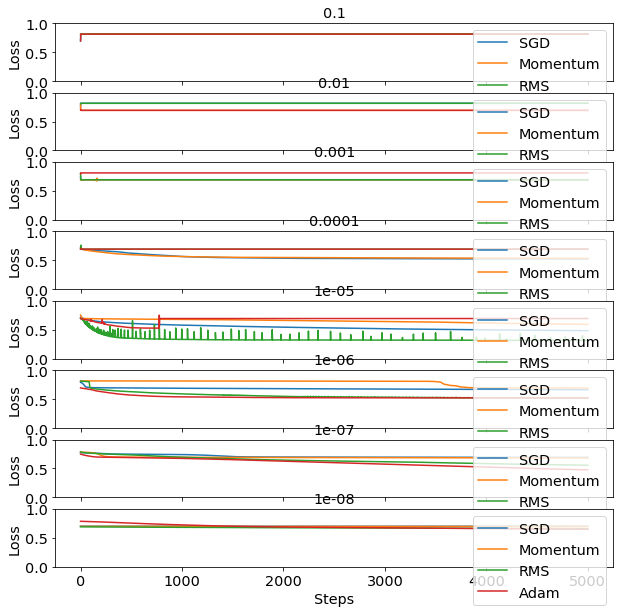

In [27]:


if train_model:
        
    learning_rates= [0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001,0.00000001]
    
    # Для каждого LR свой график
    _, axs = plt.subplots(len(learning_rates), 1, figsize=(10, 10))
    axs = axs.flatten()

    # Основной прогон по каждому LR - начинаем сначала каждый раз
    for ax,LR in zip(axs,learning_rates):
        print('LR =',LR) 
        ax.set_title(str(LR))
        
        # Создадим экземпляры сеток, передадим вид используемого оптимизатора, чтобы его печатать потом 
        net_SGD = Net(2,'SGD')
        net_SGD = net_SGD.to(device)

        net_Momentum = Net(2,'Momentum')
        net_Momentum = net_Momentum.to(device)

        net_RMSprop = Net(2,'RMS')
        net_RMSprop = net_RMSprop.to(device)

        net_Adam = Net(2,'Adam')
        net_Adam = net_Adam.to(device)
        nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]
        
        for net in nets:
            net.train() # пусть текут градиенты...


        
        opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr = LR, momentum = 0.9)
        opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr = LR, momentum = 0.8)
        opt_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr = LR, alpha = 0.9)
        opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr = LR, betas= (0.9, 0.99))
        optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]

        loss_SGD = []
        loss_Momentum = []
        loss_RMSprop =[]
        loss_Adam = []
        losses = [loss_SGD, loss_Momentum, loss_RMSprop, loss_Adam]



        for epoch in range(0, EPOCH + 1):
            if epoch % 100 == 0:
                print('Epoch= {}/{} '.format(epoch,EPOCH))                    
            for net, optimizer, loss_history in zip(nets, optimizers, losses): 
                    running_loss = 0.0
                    output = net(X)            
                    loss = loss_func(output, torch.max(target, 1)[1])
                    optimizer.zero_grad()
                    loss.backward()            
                    optimizer.step()   
                    running_loss += loss.item()
                    loss_history.append(running_loss)
                    if epoch % 100 == 0:
                        print(epoch, ':',net.name, running_loss)


        for i, loss_history in enumerate(losses):
            ax.plot(loss_history, label = nets[i].name)

        ax.legend(loc = 'best')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Loss')
        ax.set_ylim((0, 1))
        ax.label_outer()
                 


In [33]:
plt.show()  

In [15]:
# Подготовим тестовый набор к нужному формату
test = np.array([i[0] for i in test_data]).reshape(-1,dimension,dimension,3)
test = Variable(torch.Tensor(test))
test = test.reshape(-1,dimension,dimension,3)
test = test.permute(0,3,1,2)
test = test.to(device)

tlabels = np.array([i[1] for i in test_data])
tlabels = Variable(torch.Tensor(tlabels))
tlabels = tlabels.type(torch.long)
tlabels = tlabels.to(device)


In [43]:
# Визуальная проверка на выбранной нейроноке, чтобы продемонстрировать работоспособность
correct = 0
total = 0

# Процедура сохранения предсказания в список
def append_predicted(predicted_list,x):
    if x == 1: predicted_list.append([1, 0])
    else: predicted_list.append([0, 1])

train_predict = []
net_Adam.eval() # запрещаем течь градиентам

with torch.no_grad():
    for data in zip(X,target):
        images, labels = data
        images = images.reshape(1,3,dimension,dimension)
        images = images.to(device)
        outputs = net_Adam(images)
        _, predicted = torch.max(outputs, 1)
        append_predicted(train_predict,predicted)
        
        if((predicted == 0 and labels[0] == 1) or (predicted == 1 and labels[1]==1) ):
            correct+=1
total = X.shape[0]
print('Train accuracy of the network on the ' + str(total) +  ' train images: %f %%' % (
    100 * (correct*1.0) / total) )


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train accuracy of the network on the 1000 train images: 55.400000 %


In [32]:
'''
# Посмотрим на данные
n = 0
n_row = 5
n_col = 2

_, axs = plt.subplots(n_row, n_col, figsize=(15, 15))
axs = axs.flatten()

for image, label_true,label_predict, ax in zip(train_data, train_labels, train_predict, axs):
    ax.set_title(get_pet_name(label_predict))
    ax.imshow(image[0])
plt.show()   
'''

'\n# Посмотрим на train\nn = 0\nn_row = 5\nn_col = 2\n\n_, axs = plt.subplots(n_row, n_col, figsize=(10, 10))\naxs = axs.flatten()\n\nfor image, label_true,label_predict, ax in zip(train_data, train_labels, train_predict, axs):\n    ax.set_title(get_pet_name(label_predict))\n    ax.imshow(image[0])\nplt.show()   \n'